# Object Detection Demo
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/object_detection/g3doc/installation.md) before you start.

# Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import time
import tarfile
import tensorflow as tf
print tf.__file__ ###
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image


/home/censhusheng/.local/lib/python2.7/site-packages/tensorflow/__init__.pyc


## Env setup

In [2]:
# This is needed to display the images.
%matplotlib inline

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

plt.rcParams['figure.figsize'] = (20.0, 12.0)

## Object detection imports
Here are the imports from the object detection module.

In [3]:
from utils import label_map_util

from utils import visualization_utils as vis_util

## Load a (frozen) Tensorflow model into memory.

In [12]:
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = '/world/data-c9/censhusheng/train_tf_text_loc/inference_graph-2.pb'

detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [5]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'data/text_label_map.pbtxt'
NUM_CLASSES = 1

label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_indexs = label_map_util.create_category_index(categories)

## Helper code

In [6]:
def resize(image, min_size):
    width, height = image.size
    if height < width:
        new_height = int(min_size)
        new_width = int(width * min_size / height)
        if new_width % 32 != 0:
            new_width -= new_width%32
    else:
        new_width = int(min_size)
        new_height = int(height * min_size / width)
        if new_height % 32 != 0:
            new_height -= new_height%32
    print 'resize:', (width, height), '->', (new_width, new_height) ###
    return image.resize((new_width, new_height), Image.BILINEAR)



def load_image_into_numpy_array(input_image, min_size=800):
    image = resize(input_image, min_size)
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)


import math
def rbox_2_polygon(xc, yc, w, h, rad):
    if w <1 or h <1:
        return None
    w2 = w/2
    h2 = h/2
    m_rot = np.array([[np.cos(rad), -np.sin(rad)], 
                      [np.sin(rad), np.cos(rad)]], dtype=np.float32)
    pts_ = np.array([[-w2,-h2],
                     [w2,-h2],
                     [w2,h2],
                     [-w2,h2]], dtype=np.float32)
    pts = np.dot(m_rot, pts_.T).T
    pts[:,0] = pts[:,0] + xc
    pts[:,1] = pts[:,1] + yc
    return pts.flatten().tolist()



from skimage.draw import polygon
def show_polygons(im, polygons):
    assert polygons.shape[1] == 8
    for p in polygons:
        rr, cc = polygon(p[1::2], p[0::2])
        rr = np.clip(rr, 0, im.shape[0]-1)
        cc = np.clip(cc, 0, im.shape[1]-1)
        alpha = 0.5 # set alpha of marker
        im[rr, cc, 0] = alpha * 255 + im[rr, cc, 0] * (1 - alpha)
        im[rr, cc, 1] = im[rr, cc, 1] * (1 - alpha)
        im[rr, cc, 2] = im[rr, cc, 2] * (1 - alpha)
        im[p[1]-1:p[1]+2, p[0]-1:p[0]+2] = np.array([0,255,0], dtype=np.uint8) # green for first point
        im[p[3]-1:p[3]+2, p[2]-1:p[2]+2] = np.array([0,0,255], dtype=np.uint8) # blue for second point
    plt.imshow(im);plt.show()

# LA-NMS

In [7]:
sys.path.append(os.path.expanduser('~/github/EAST/'))
import lanms
print lanms

<module 'lanms' from '/home/censhusheng/github/EAST/lanms/__init__.pyc'>


# Detection

In [13]:


TRAIN_IMAGE_PATHS = [
#    '/world/data-c7/censhusheng/data/MSRA-TD500/test/IMG_0059.JPG',
#    '/world/data-c7/censhusheng/data/MSRA-TD500/test/IMG_0080.JPG',
#    '/world/data-c7/censhusheng/data/MSRA-TD500/train/IMG_0030.JPG',

    '/world/data-c7/censhusheng/data/icdar2015-Incidental_Scene_Text/train_images/img_1.jpg',
    '/world/data-c7/censhusheng/data/icdar2015-Incidental_Scene_Text/train_images/img_10.jpg',
    '/world/data-c7/censhusheng/data/icdar2015-Incidental_Scene_Text/train_images/img_100.jpg',
    '/world/data-c7/censhusheng/data/icdar2015-Incidental_Scene_Text/train_images/img_200.jpg',
    '/world/data-c7/censhusheng/data/icdar2015-Incidental_Scene_Text/train_images/img_300.jpg',
    '/world/data-c7/censhusheng/data/icdar2013-Focused_Scene_Text/train_images/100.jpg',
    '/world/data-c7/censhusheng/data/icdar2013-Focused_Scene_Text/train_images/101.jpg',
    '/world/data-c7/censhusheng/data/icdar2013-Focused_Scene_Text/train_images/102.jpg',
    '/world/data-c7/censhusheng/data/icdar2013-Focused_Scene_Text/train_images/103.jpg',
    '/world/data-c7/censhusheng/data/icdar2013-Focused_Scene_Text/train_images/104.jpg',
]

TEST_IMAGE_PATHS = [
    '/world/data-c7/censhusheng/data/icdar2015-Incidental_Scene_Text/test_images/img_1.jpg',
    '/world/data-c7/censhusheng/data/icdar2015-Incidental_Scene_Text/test_images/img_5.jpg',
    '/world/data-c7/censhusheng/data/icdar2015-Incidental_Scene_Text/test_images/img_9.jpg',
    '/world/data-c7/censhusheng/data/icdar2015-Incidental_Scene_Text/test_images/img_15.jpg',
]


resize: (1280, 720) -> (1280, 736)
net_time: 1.2974550724 num_detections: [ 50.]
convert_time: 0.00217795372009
nms_time: 0.000548124313354 boxes: 3
[ 11.91987514   8.97728729   7.97062969]


/usr/lib/python2.7/site-packages/ipykernel_launcher.py:55: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/lib/python2.7/site-packages/ipykernel_launcher.py:56: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


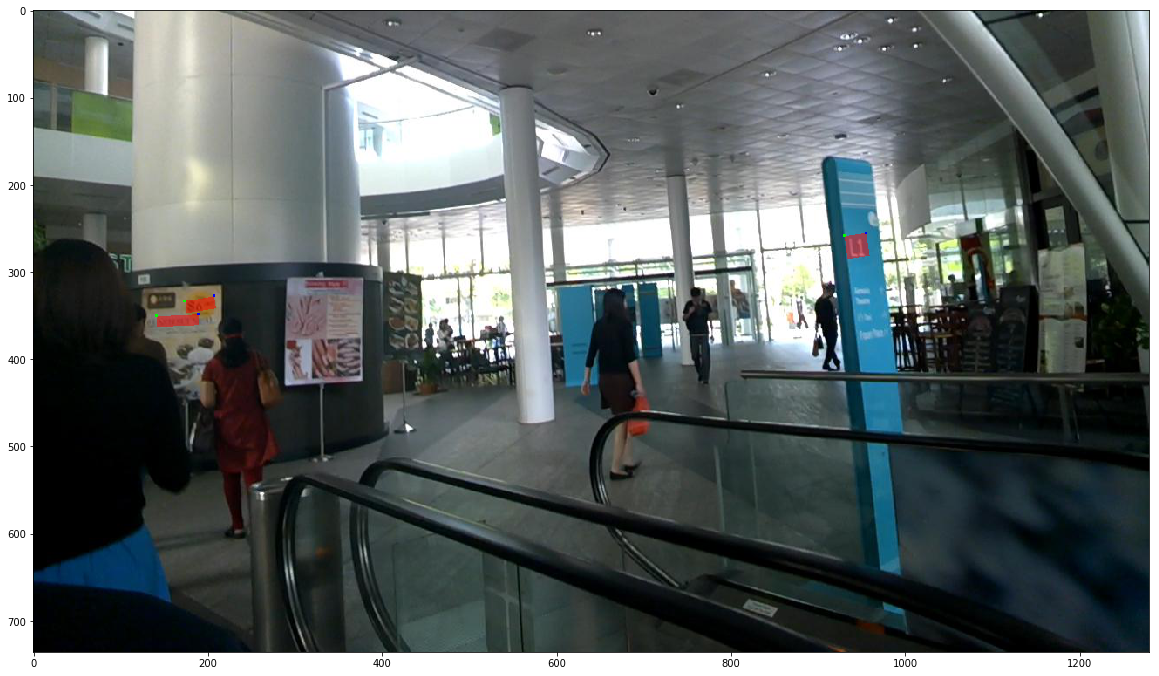

resize: (1280, 720) -> (1280, 736)
net_time: 0.0505290031433 num_detections: [ 142.]
convert_time: 0.00654697418213
nms_time: 0.00135016441345 boxes: 5
[ 49.73035812  30.67185783  18.50341606  16.81181335  15.99360752]


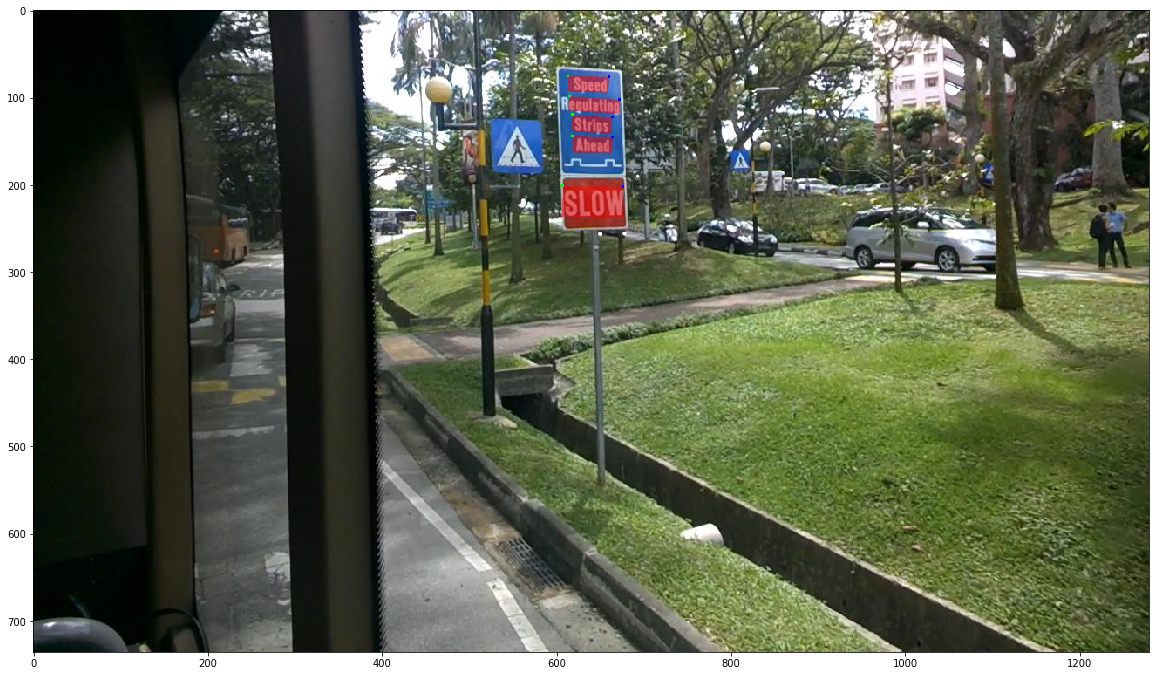

resize: (1280, 720) -> (1280, 736)
net_time: 0.0501689910889 num_detections: [ 305.]
convert_time: 0.0130388736725
nms_time: 0.00218200683594 boxes: 5
[ 92.45912933  78.50828552  67.57473755  22.4555912    8.8609848 ]


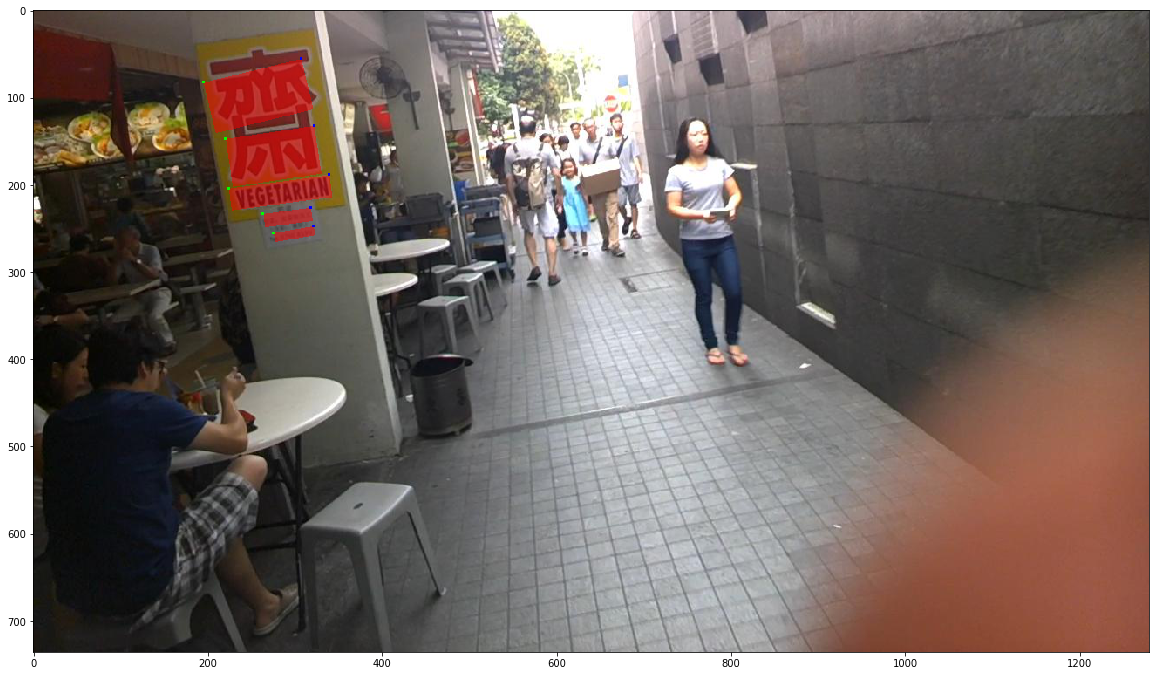

resize: (1280, 720) -> (1280, 736)
net_time: 0.050411939621 num_detections: [ 254.]
convert_time: 0.0133450031281
nms_time: 0.00219202041626 boxes: 6
[ 71.78543854  67.65885162  26.43471718  14.7894268   11.75905037
   8.9368906 ]


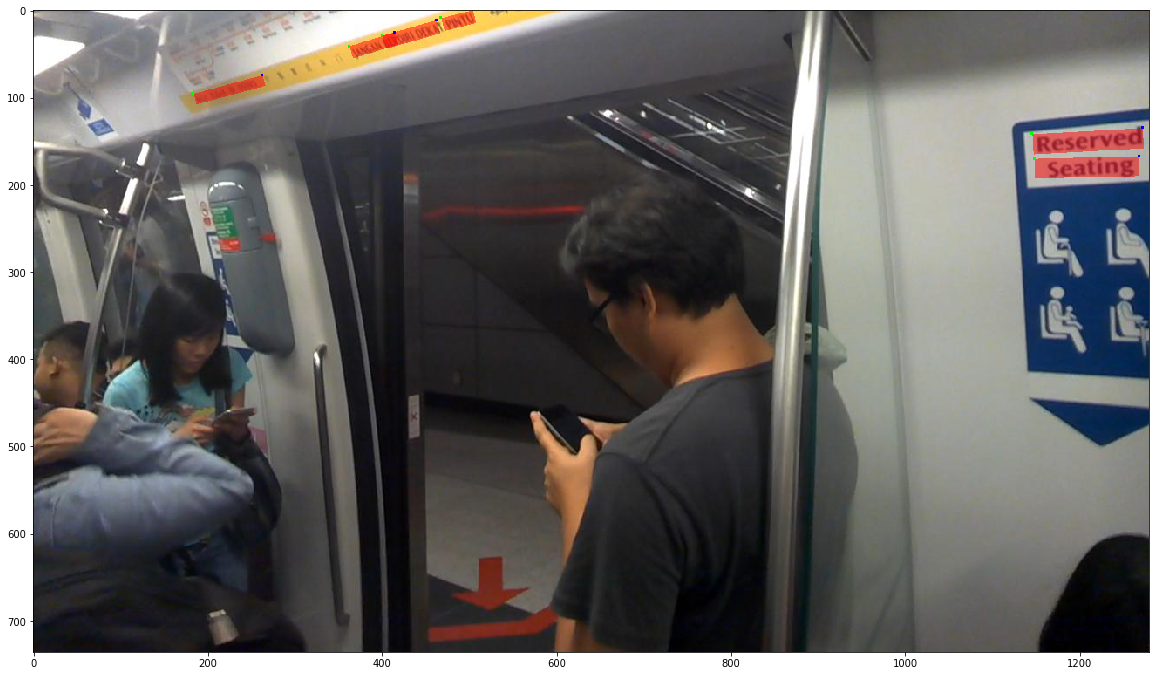

In [15]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5

with detection_graph.as_default():
    with tf.Session(graph=detection_graph, config=config) as sess:
        for image_path in TEST_IMAGE_PATHS:
            image = Image.open(image_path)
            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
            image_np = load_image_into_numpy_array(image, 736)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            # Each box represents a part of the image where a particular object was detected.
            boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            # Each score represent how level of confidence for each of the objects.
            # Score is shown on the result image, together with the class label.
            scores = detection_graph.get_tensor_by_name('detection_scores:0')
            classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')
    
            # Actual detection.
            t0 = time.time()
            (boxes, scores, classes, num_detections) = sess.run(
                [boxes, scores, classes, num_detections],
                feed_dict={image_tensor: image_np_expanded})
            print 'net_time:', time.time() - t0, 'num_detections:', num_detections ###
            
            if num_detections[0] < 1:
                continue

            # convert rbox to polygon
            t0 = time.time()
            boxes = np.squeeze(boxes)
            yc = (boxes[:,0] + boxes[:,2]) / 2
            xc = (boxes[:,1] + boxes[:,3]) / 2
            h = boxes[:,2] - boxes[:,0]
            w = boxes[:,3] - boxes[:,1]
            scores = np.squeeze(scores)
            polys = []
            score_thresh = 0.8 # <<<<<<<<<<<<<<<<<<<<<<<
            for i in range(num_detections[0]):
                if scores[i] < score_thresh:
                    continue
                p = rbox_2_polygon(xc[i], yc[i], w[i], h[i], boxes[i,4])
                if p is not None:
                    polys.append(p + [scores[i]])
            polys = np.array(polys, dtype=np.float32)
            print 'convert_time:', time.time() - t0
            
            # lanms            
            nms_thres = 0.2  # <<<<<<<<<<<<<<<<<<<<<<<<<<
            t0 = time.time()
            polys = lanms.merge_quadrangle_n9(polys, nms_thres)
            
            nms_keep_thres = 5.0 # <<<<<<<<<<<<<<<<<<<<<<<<
            polys = polys[np.where(polys[:,8] > nms_keep_thres)[0]]
            print 'nms_time:', time.time() - t0, 'boxes:', polys.shape[0] 
            
            # Visualization of the results of a detection.
            print polys[:,8]
            show_polygons(image_np, polys[:,:8])

# predict on ICDAR2015 test set

In [9]:
data_dir = '/world/data-c7/censhusheng/data/icdar2015-Incidental_Scene_Text/test_images/'

output_dir = '/world/data-c7/censhusheng/data/icdar2015-Incidental_Scene_Text/script_test/test'

In [ ]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5

with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        for i, fn in enumerate(os.listdir(data_dir)):
            print '\n', i, fn ###
            t_ = time.time()
            image = Image.open(os.path.join(data_dir, fn))
            width, height = image.size
            image_np = load_image_into_numpy_array(image)
            new_width, new_height = image.size
            ratio_x = float(width)/image_np.shape[1]
            ratio_y = float(height)/image_np.shape[0]
            print 'resize time:', time.time() - t_ ###
            
            image_np_expanded = np.expand_dims(image_np, axis=0)
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

            boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            scores = detection_graph.get_tensor_by_name('detection_scores:0')
            classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')

            # Actual detection.
            t0 = time.time()
            (boxes, scores, classes, num_detections) = sess.run(
                [boxes, scores, classes, num_detections],
                feed_dict={image_tensor: image_np_expanded})
            print 'net time:', time.time() - t0, 'num_detections:', num_detections ###

            # convert rbox to polygon
            t0 = time.time()
            boxes = np.squeeze(boxes)
            yc = (boxes[:,0] + boxes[:,2]) / 2
            xc = (boxes[:,1] + boxes[:,3]) / 2
            h = boxes[:,2] - boxes[:,0]
            w = boxes[:,3] - boxes[:,1]
            scores = np.squeeze(scores)
            polys = []
            for i in range(num_detections[0]):
                if scores[i] < 0.9:
                    continue
                p = rbox_2_polygon(xc[i], yc[i], w[i], h[i], boxes[i,4])
                if p is not None:
                    polys.append(p + [scores[i]])
            polys = np.array(polys, dtype=np.float32)
            print 'convert time:', time.time() - t0 ###
            
            # lanms
            nms_thres = 0.2
            t0 = time.time()
            polys = lanms.merge_quadrangle_n9(polys, nms_thres)
            thres = 10.0
            if polys.shape[0] > 0:
                remain_index = np.where(polys[:,8] > thres)[0]
                polys = polys[remain_index]
            print 'nms_time:', time.time() - t0, 'boxes:', polys.shape[0]  ###
            
            # save results
            res_fn = 'res_' + os.path.splitext(fn)[0] + '.txt'
            with open(os.path.join(output_dir, res_fn), 'w') as f_res:
                for p in polys:
                    f_res.write("{:d},{:d},{:d},{:d},{:d},{:d},{:d},{:d}\r\n".format(
                        int(p[0] * ratio_x),
                        int(p[1] * ratio_y),
                        int(p[2] * ratio_x),
                        int(p[3] * ratio_y),
                        int(p[4] * ratio_x),
                        int(p[5] * ratio_y),
                        int(p[6] * ratio_x),
                        int(p[7] * ratio_y),
                    ))
            print 'total time:', time.time() - t_